In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#download the dataset content from google drive to google colab vm
!cp -r /content/drive/MyDrive/CIDL_Project/dataset/preprocessed_annotations/preprocessed_annotations .
!cp -r /content/drive/MyDrive/CIDL_Project/dataset/preprocessed_images/preprocessed_images .

In [3]:
import tensorflow as tf

image_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='./preprocessed_images',
    labels = None,
    label_mode=None,
    batch_size=None,
    color_mode='rgb',
    image_size=(224, 224),
    shuffle=False,
    crop_to_aspect_ratio=False,
)

Found 1861 files belonging to 1 classes.


In [4]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["without mask", "with mask"]

def visualize_image(image, figsize=(7, 7)):
    image = np.array(image, dtype=np.uint8)
    plt.figure()
    plt.axis("off")
    plt.imshow(image)
    return plt

def visualize_images(images, figsize=(7, 7)):
  for image in images:
    visualize_image(image, figsize)

def visualize_detections(
    image, box, label, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    plt = visualize_image(image)
    ax = plt.gca()
    text = "{}:".format(labels[label])
    x1, y1, x2, y2 = box
    w, h = x2 - x1, y2 - y1
    patch = plt.Rectangle(
        [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
    )
    ax.add_patch(patch)
    ax.text(
        x1,
        y1,
        text,
        bbox={"facecolor": color, "alpha": 0.4},
        clip_box=ax.clipbox,
        clip_on=True,
    )
    plt.show()
    return ax

In [5]:
def rescale_bbox(image_shape, bbox):
  return tf.stack(
        [
            bbox[0] * image_shape[1],
            bbox[1] * image_shape[0],
            bbox[2] * image_shape[1],
            bbox[3] * image_shape[0]
        ])

In [6]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

def convert_to_minmax(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

In [7]:
def flip_horizontal(image, boxes):
    flipped_image = tf.image.flip_left_right(image)
    flipped_boxes = tf.stack(
        [1 - boxes[0], boxes[1], boxes[2], boxes[3]], axis=-1
    )
    return flipped_image, flipped_boxes

In [8]:
def preprocess_data(sample):
    normalized_xmin = sample["xmin"] / sample["width"]
    normalized_ymin = sample["ymin"] / sample["height"]
    normalized_xmax = sample["xmax"] / sample["width"]
    normalized_ymax = sample["ymax"] / sample["height"]
    bounding_box = [normalized_xmin, normalized_ymin, normalized_xmax, normalized_ymax]
    bboxes = tf.convert_to_tensor(bounding_box)
    bboxes = convert_to_xywh(bboxes)
    label = tf.convert_to_tensor(sample["label"], dtype=tf.float32)
    ground_truth = tf.stack(
        [
            bboxes[0],
            bboxes[1],
            bboxes[2],
            bboxes[3]
        ],
        axis=-1,
    )
    return ground_truth, label

In [9]:
import os

path = "preprocessed_annotations"
i = 0

annotations = os.listdir(path)
annotations.sort()

list_of_features = []
list_of_bboxes = []
list_of_labels = []
for image in image_dataset:
  
  file_name = annotations[i]
  file_path = os.path.join(path, file_name)
  sample = {}
  
  with open(file_path, 'r') as f:
    sample["width"] = int(f.readline())
    sample["height"] = int(f.readline())
    sample["xmin"] = int(f.readline())
    sample["ymin"] = int(f.readline())
    sample["xmax"] = int(f.readline())
    sample["ymax"] = int(f.readline())
    sample["label"] = int(f.readline()) - 1
    bounding_box, label = preprocess_data(sample)    
  list_of_features.append(image)
  list_of_bboxes.append(bounding_box)
  list_of_labels.append(label)
  if sample["label"] == 0:
    flipped_image, flipped_bbox = flip_horizontal(image, bounding_box)
    list_of_features.append(flipped_image)
    list_of_bboxes.append(flipped_bbox)
    list_of_labels.append(label)
  i = i + 1
  if (i % 200 == 0):
    print(i)

feature_tensor = tf.convert_to_tensor(list_of_features)
bounding_box_tensor = tf.convert_to_tensor(list_of_bboxes)
labels_tensor = tf.convert_to_tensor(list_of_labels)

test_set_size = int(np.floor(feature_tensor.shape[0]*0.2))

200
400
600
800
1000
1200
1400
1600
1800


In [10]:
feature_tensor.shape

TensorShape([2141, 224, 224, 3])

In [11]:
random_seed = 100
tf.random.set_seed(random_seed)
feature_tensor = tf.random.shuffle(feature_tensor)
tf.random.set_seed(random_seed)
bounding_box_tensor = tf.random.shuffle(bounding_box_tensor)
tf.random.set_seed(random_seed)
labels_tensor = tf.random.shuffle(labels_tensor)

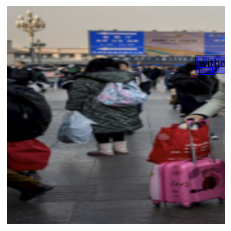

In [12]:
index = 290
bbox = convert_to_minmax(bounding_box_tensor[index])
scaled_bbox = rescale_bbox(feature_tensor[index].shape, bbox)
visualize_detections(feature_tensor[index], scaled_bbox, int(labels_tensor[index].numpy()))

In [13]:
feature_test_set = feature_tensor[:test_set_size]
feature_tensor = feature_tensor[test_set_size:]
bounding_box_test_set = bounding_box_tensor[:test_set_size]
bounding_box_tensor = bounding_box_tensor[test_set_size:]
labels_test_set = labels_tensor[:test_set_size]
labels_tensor = labels_tensor[test_set_size:]

In [14]:
tf.reduce_sum(tf.cast(tf.equal(labels_tensor, 0), tf.int32))

<tf.Tensor: shape=(), dtype=int32, numpy=437>

In [15]:
def IoU_metric(y_true, y_pred):
    boxes1_corners = convert_to_minmax(y_true)
    boxes2_corners = convert_to_minmax(y_pred)
    lu = tf.maximum(boxes1_corners[:, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, 0] * intersection[:, 1]
    boxes1_area = y_true[:, 2] * y_true[:, 3]
    boxes2_area = y_pred[:, 2] * y_pred[:, 3]  
    union_area = tf.maximum(
        boxes1_area + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [16]:
print("The feature tensor shape is: " + str(feature_tensor.shape))
print("The bounding_box tensor shape is: " + str(bounding_box_tensor.shape))
print("The labels tensor shape is: " + str(labels_tensor.shape))

The feature tensor shape is: (1713, 224, 224, 3)
The bounding_box tensor shape is: (1713, 4)
The labels tensor shape is: (1713,)


In [17]:
print("The test feature tensor shape is: " + str(feature_test_set.shape))
print("The test bounding_box tensor shape is: " + str(bounding_box_test_set.shape))
print("The test labels tensor shape is: " + str(labels_test_set.shape))

The test feature tensor shape is: (428, 224, 224, 3)
The test bounding_box tensor shape is: (428, 4)
The test labels tensor shape is: (428,)


# MODELS TRAINING

In [18]:
import keras
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler,ModelCheckpoint,EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from keras.layers import Input,AveragePooling2D,Dense, Dropout, Flatten
from tensorflow.keras.models import Model

## MobileNetV2

In [19]:
mobilenet_base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [20]:
mobilenet_base_model.trainable = False

In [21]:
input_tensor = keras.Input(shape=(224, 224,3),name="input")

In [22]:
headModel = tf.keras.applications.mobilenet_v2.preprocess_input(input_tensor)
headModel = mobilenet_base_model(headModel)
headModel = tf.keras.layers.GlobalAveragePooling2D()(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
classification_head = keras.layers.Dense(1, activation='sigmoid', name="labels")(headModel)
regression_head = keras.layers.Dense(4, activation='sigmoid', name="bounding_box")(headModel)

In [23]:
mobilenet_model = keras.Model(
    inputs=input_tensor,
    outputs=[classification_head, regression_head],
)

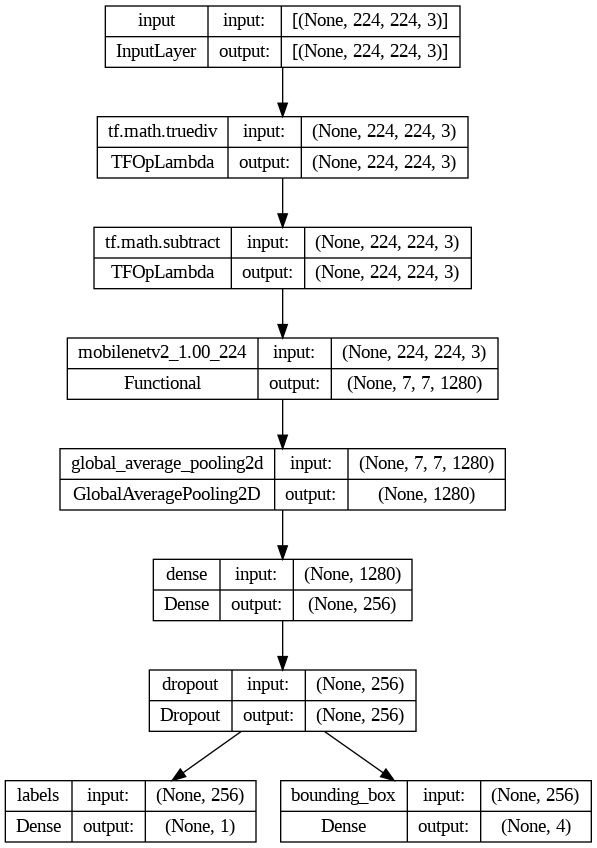

In [24]:
tf.keras.utils.plot_model(mobilenet_model, show_shapes=True)

In [25]:
mobilenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['input[0][0]']                  
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['tf.math.subtract[0][0]']   

In [26]:
mobilenet_model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(),
        keras.losses.MeanSquaredError(),
    ],
    loss_weights=[0.1, 1.0],
    metrics={'labels':'accuracy', 'bounding_box': [IoU_metric]}
)

model_dir = "models/"
experiment = "lorenzo_mobilenet_pretrained_1.h5"
save_path = os.path.join(model_dir, experiment)


callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
]

In [27]:
history = mobilenet_model.fit(
              {"input": feature_tensor},
              {"labels": labels_tensor, "bounding_box": bounding_box_tensor},
              epochs=10,
              batch_size=32,
              validation_split=0.2,
              shuffle=True,
              callbacks = callbacks_list
          )

Epoch 1/10
43/43 [==============================] - ETA: 0s - loss: 0.1147 - labels_loss: 0.6045 - bounding_box_loss: 0.0543 - labels_accuracy: 0.7650 - bounding_box_IoU_metric: 0.0603
Epoch 1: val_loss improved from inf to 0.05789, saving model to models/lorenzo_mobilenet_pretrained_1.h5
43/43 [==============================] - 33s 711ms/step - loss: 0.1147 - labels_loss: 0.6045 - bounding_box_loss: 0.0543 - labels_accuracy: 0.7650 - bounding_box_IoU_metric: 0.0603 - val_loss: 0.0579 - val_labels_loss: 0.4098 - val_bounding_box_loss: 0.0169 - val_labels_accuracy: 0.8222 - val_bounding_box_IoU_metric: 0.1550
Epoch 2/10
43/43 [==============================] - ETA: 0s - loss: 0.0617 - labels_loss: 0.3799 - bounding_box_loss: 0.0237 - labels_accuracy: 0.8219 - bounding_box_IoU_metric: 0.1178
Epoch 2: val_loss did not improve from 0.05789
43/43 [==============================] - 29s 687ms/step - loss: 0.0617 - labels_loss: 0.3799 - bounding_box_loss: 0.0237 - labels_accuracy: 0.8219 - bou

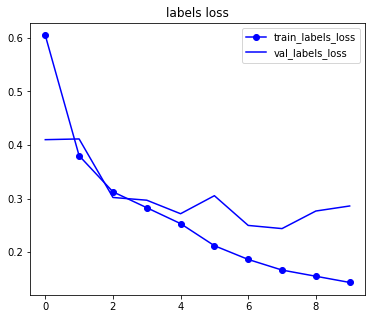

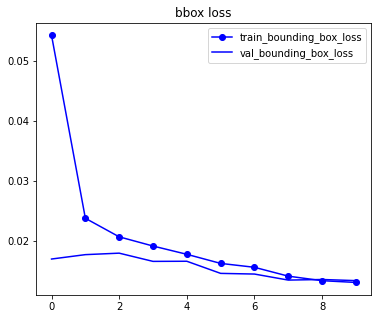

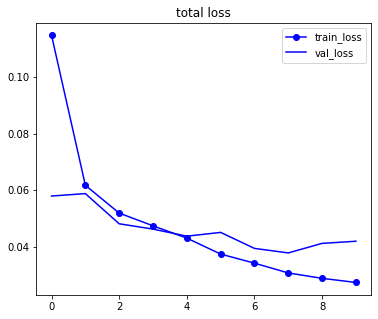

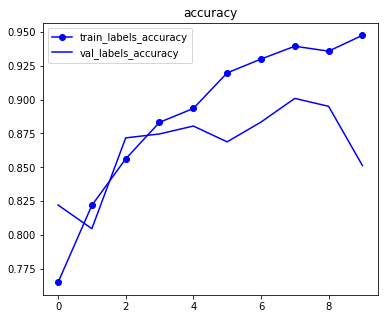

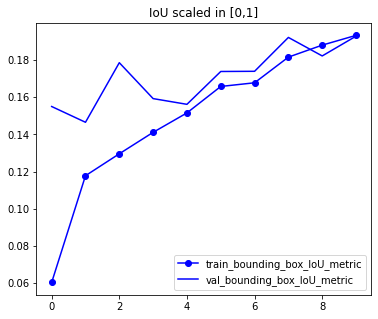

In [28]:
plt.figure(figsize=(6,5))
plt.title('labels loss')
plt.plot(history.history['labels_loss'],'bo-',label = 'train_labels_loss')
plt.plot(history.history['val_labels_loss'],'b-',label = 'val_labels_loss')
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.title('bbox loss')
plt.plot(history.history['bounding_box_loss'],'bo-',label = 'train_bounding_box_loss')
plt.plot(history.history['val_bounding_box_loss'],'b-',label = 'val_bounding_box_loss')
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.title('total loss')
plt.plot(history.history['loss'],'bo-',label = 'train_loss')
plt.plot(history.history['val_loss'],'b-',label = 'val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.title('accuracy')
plt.plot(history.history['labels_accuracy'],'bo-',label = 'train_labels_accuracy')
plt.plot(history.history['val_labels_accuracy'],'b-',label = 'val_labels_accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.title('IoU scaled in [0,1]')
plt.plot(history.history['bounding_box_IoU_metric'],'bo-',label = 'train_bounding_box_IoU_metric')
plt.plot(history.history['val_bounding_box_IoU_metric'],'b-',label = 'val_bounding_box_IoU_metric')
plt.legend()
plt.show()

In [29]:
# try to load the model again
from tensorflow.keras.models import load_model

del mobilenet_model

mobilenet_model = load_model(os.path.join(model_dir, "lorenzo_mobilenet_pretrained_1.h5"), custom_objects={"IoU_metric": IoU_metric})
mobilenet_model.evaluate({"input": feature_test_set},
               {"labels": labels_test_set, "bounding_box": bounding_box_test_set}, 
               return_dict=True)

14/14 [==============================] - 8s 522ms/step - loss: 0.0413 - labels_loss: 0.2837 - bounding_box_loss: 0.0129 - labels_accuracy: 0.8902 - bounding_box_IoU_metric: 0.1909


{'loss': 0.04131172224879265,
 'labels_loss': 0.2837042212486267,
 'bounding_box_loss': 0.012941298075020313,
 'labels_accuracy': 0.8901869058609009,
 'bounding_box_IoU_metric': 0.1909441202878952}

0


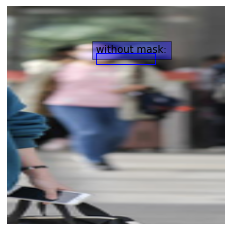

1


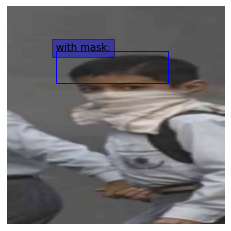

1


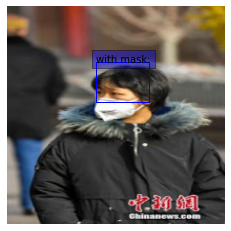

0


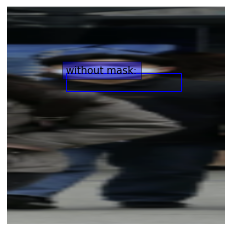

1


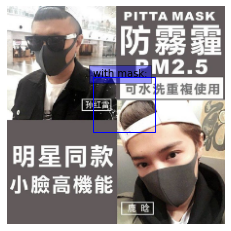

1


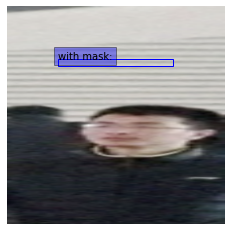

1


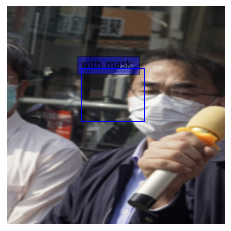

1


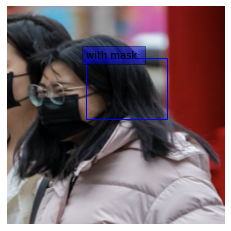

1


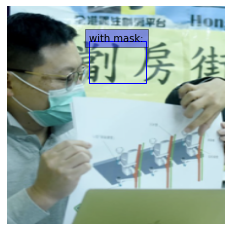

0


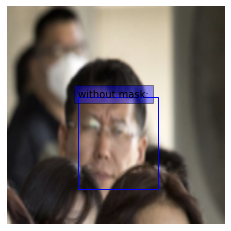

In [30]:
results = mobilenet_model(feature_test_set[0:10])
labels_list = []
for i in range(10):
  label = tf.cast(tf.round(results[0][i]), dtype=tf.int32)
  print(label[0].numpy())
  bbox = convert_to_minmax(results[1][i])
  scaled_bbox = rescale_bbox(feature_test_set[i].shape, bbox)
  visualize_detections(feature_test_set[i], scaled_bbox, label[0].numpy())

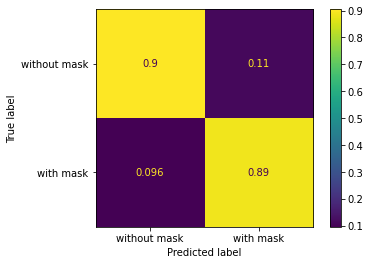

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = mobilenet_model(feature_test_set)
result = confusion_matrix(labels_test_set, tf.cast(tf.math.round(predictions[0]), dtype=tf.int32), normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['without mask', 'with mask'])
disp.plot()
plt.show()

In [32]:
!cp ./models/lorenzo_mobilenet_pretrained_1.h5 /content/drive/MyDrive/CIDL_Project/models/